# 05_Smart_Charging

This notebook deals with task 5, smart charging. It defines an environment and a Markov decision process with states, actions, and rewards. The agent is initialized with a random battery capacity, has random energy demand, and finds an optimal policy to take the optimal action given the current time and charge. <br> <br> 

The notebook is structured as follows:

* Charging Environment
    * Environment
    * Distribution of Demand
    * Complementary Methods 

* Solution Approaches 
    * SARSA 
    * Q-Learning
    * Double Q-Learning 
* Comparison of Results
    * Rewards and Initial Battery Charges
    * Final Battery Charges

In [1]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import math
import gym
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

## Charging Environment

First, we need to define the environment for our charging agent. To do so, we create a customized gym environment. Here, we initialize and reset the environment and its properties. We also define the rewards for actions as well as the proceding state.

### Environment

When the environment is initialized, it starts at 2 PM with a random integer battery charge in the range of ???? to ????. It lets the agent select a charging rate at each time step (every 15 minutes until 4 PM). It then charges the battery depending on the charging rate and calculates the rewards. At 4 PM, it checks whether or not the battery demand (stochastic value coming from a normal distribution with mean of 30 and standard deviation of 5) exceeds the battery charge. In case the battery charge is lower than the energy demand, the environment adds the corresponding penalty to the list of rewards.

We also define the following Markov decision process: <br>
* States: All permutations of the possible points in time (2 PM, 2:15 PM, ..., 4 PM) combined with all (theoretically) possible battery charges (0 kWh, 1 kWh, ..., 60 kWh) <br> <br>
* Actions: The defined charging rate (here 0, 4, 8, 12, 16, or 20 kW) <br><br>
* Reward Function: Negative rewards at each time step following an exponential function of the charging rate: (t,p) = (∑(𝑡∈𝑇) 𝛼(𝑡) * 𝑒^𝑝) * (-1), as well as very high negative rewards (-1000000000) in case the battery charge is lower than the energy demand

In [2]:
# Define the ChargingEnvironment class
class ChargingEnvironment(gym.Env):
    """
    Defines the environment for the smart charging reinforcement learning agent
    """
    def __init__(self, mu, sigma, battery_capacity, highest_rate):
        """
        Initializes the environment
    
        Args: 
            self: Instance of ChargingEnvironment
            mu: The mean value of energy demand distribution
            sigma: The standard deviation of energy demand distribution
            battery_capacity: Vehicle's maximum battery capacity
            highest_rate: Highest battery charging rate

        """
        
        super(ChargingEnvironment, self).__init__()
        self.mu = mu
        self.sigma = sigma
        self.battery_capacity = battery_capacity
        self.highest_rate = highest_rate
        self.action_space = gym.spaces.Discrete(6)  # Discrete action space
        self.observation_space = gym.spaces.Box(low=np.array([0, 0]), high=np.array([24, battery_capacity]))

    def reset(self):
        """
        Resets the current environment's time, battery charge, and energy demand
    
        Args: 
            self: Instance of ChargingEnvironment
            
        Returns:
            self.current_time: Time after reset
            self.current_charge: Charge after reset
        """
        self.current_time = 2  # Starting time (2 p.m.)
        self.current_charge = random.randint(20, 25)
        self.energy_demand = np.random.normal(self.mu, self.sigma)
        return np.array([self.current_time, self.current_charge])

    def step(self, action):
        """
        Executes a time step given the state of the environment and the selected action. Updates the state and the rewards
    
        Args: 
            self: Instance of ChargingEnvironment
            action: Action selected by the agent
            
        Returns:
            next_state: Next state of the environment
            reward: Rewards given the selected action
            done: Whether or not episode is over
        """
        done = False
        charging_power = np.clip(action * 4, 0, self.highest_rate)  # Limit charging_power to [0, 4, 8, 12, 16, 20]
        energy_charging = charging_power / 4  # Energy charging in 15 minutes
        self.current_time += 0.25  # Increment time by 15 minutes
        self.current_charge += energy_charging
        if(self.current_charge > self.battery_capacity):
            self.current_charge = self.battery_capacity
        if(charging_power == 0):
            reward = 0
        else:
            reward = (0.25 * math.exp(charging_power)) * -1

        if self.current_time >= 4:
            if self.current_charge - self.energy_demand <= 0:
                reward -= 1000000000
            done = True
        next_state = np.array([self.current_time, self.current_charge])
        return next_state, reward, done, {}

### Distribution of Demand

Now, let us have a look at the distribution of energy demand.

Probability of value being higher than 40: 0.0228
Probability of value being higher than 41: 0.0139
Probability of value being higher than 42: 0.0082
Probability of value being higher than 43: 0.0047
Probability of value being higher than 44: 0.0026
Probability of value being higher than 45: 0.0013
Probability of value being higher than 46: 0.0007
Probability of value being higher than 47: 0.0003
Probability of value being higher than 48: 0.0002
Probability of value being higher than 49: 0.0001
Probability of value being higher than 50: 0.0000
Probability of value being higher than 60: 0.0000


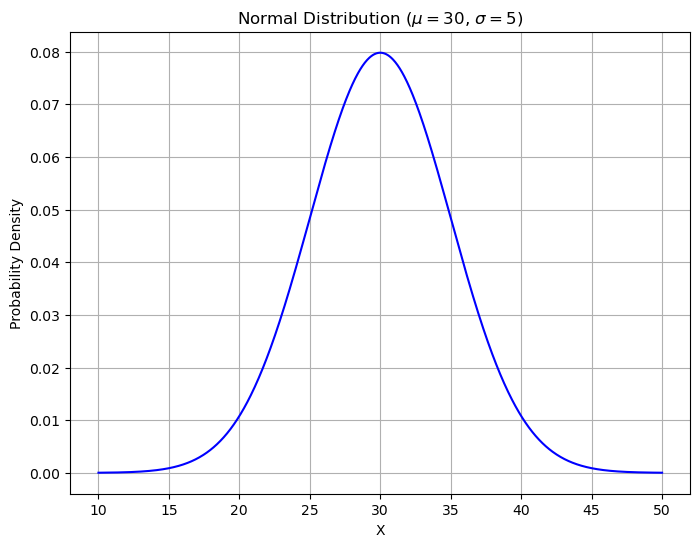

In [3]:
"""
Draws the density function of energy demand along with the threshold probabilities

"""
# Parameters for normal distribution
mean = 30
sigma = 5

# Threshold values
thresholds = [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 60]

# Calculate probabilities
probabilities = [1 - stats.norm.cdf(threshold, loc = mean, scale = sigma) for threshold in thresholds]

# Print the probabilities
for threshold, prob in zip(thresholds, probabilities):
    print(f"Probability of value being higher than {threshold}: {prob:.4f}")


# Generate data points for the x-axis
x = np.linspace(mean - 4 * sigma, mean + 4 * sigma, 1000)

# Calculate the corresponding probability density function (PDF) values
pdf = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mean)**2 / (2 * sigma**2))

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, pdf, color='blue')
plt.title('Normal Distribution ($\mu=30$, $\sigma=5$)')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()


We can see that the probability of the demand exceeding 40 kWh is lower than 2.5 %, the probability for more than 45 kWh is lower than 0.15 %, and the probability for more than 50 kWh is 0.00 %. Thus, the maximum battery capacity of 60 kWh is not realistically exceeded by the demand. <br> <br>
Considering the probabilities for 45 to 50 kWh, we can assume that the agent(s) will probably aim at charging the battery up to that range to avoid the penalty for running out of charge.

### Complementary Methods

Here, we want to check whether or not the learnt Q-tables induce a (near-)optimal policy.

In [4]:
def plotRunningAverage(totalrewards):
    """
    Plots the running average of rewards over time
    
    Args: 
        totalrewards: The total rewards of an episode
        
    """
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(totalrewards[max(0, t-100):(t+1)])
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

In [5]:
def printOptimalActionsAndRewards(Q1, Q2, env, lowest_init, highest_init):
    """
    Prints a random episode using random initialization and action selection using the learnt Q-table

    Args:
        Q1: The Q-table learnt by the algorithm; Q1 table for Double Q-Learning
        Q2: Q2 table for Double Q-Learning
        env: The initialized ChargingEnvironment
        
    Returns:
        totalrewards_optimal: Array with sum of rewards for each initial value
        final_charge: Array with final battery charge value for each initial value 
    """
    init_value = lowest_init
    totalrewards_optimal = np.zeros(60)
    final_charge = np.zeros(60)
    while (init_value <= highest_init):
        done = False
        state = ChargingEnvironment.reset(env) 
        state[1] = init_value
        env.current_charge = init_value
        totalrewards_optimal[init_value] = 0
        while not done:
            if(Q2 == 0):
                action = maxAction(Q1, state)
            else:
                action = maxActionDQL(Q1,Q2,state)
            next_state, reward, done, info = ChargingEnvironment.step(env, action)

            print("Time =", state[0])
            print("Charge =", state[1])
            print("Optimal Action =", action)
            print("Reward =", reward)
            print()

            totalrewards_optimal[init_value] += reward
            state = next_state

        print("Time =", state[0])
        print("Charge =", state[1])
        final_charge[init_value] = state[1]
        print("Total Reward =", totalrewards_optimal[init_value])
        print()
        init_value += 1
    return (totalrewards_optimal, final_charge)

In [6]:
def plotOptimalRewards(rewards, lowest_init, highest_init):
    """
    Plots the sum of rewards for the given agent and the respective range of initial values
    
    Args:
        rewards: Sum of rewards for the respective range of initial values
        lowest_init: Lowest initial value
        highest_init: Highest initial value
    """
    plt.plot(rewards[lowest_init : (highest_init + 1)])
    plt.xlabel('Initial Charge Values')
    plt.ylabel('Rewards')
    plt.title('Rewards vs. Initial Charge Values')
    positions = list(range(lowest_init, (highest_init + 1)))
    plt.xticks(range(len(rewards[lowest_init : (highest_init + 1)])), positions)
    plt.show()

In [7]:
def getQTable(Q):
    """
    Creates a dataframe using the learnt Q-table

    Args:
        Q: The Q-table learnt by the algorithm
        
    Returns:
        df: The dataframe containing the Q-table
    """
    
    # Extract keys and values from the dictionary
    keys = list(Q.keys())
    values = list(Q.values())

    # Separate the keys into time, charge, action, and index components
    time_list = [key[0][0] for key in keys]
    charge_list = [key[0][1] for key in keys]
    action_list = [key[1] for key in keys]
    value_list = values

    # Create a dictionary from the lists
    data = {
        'Time': time_list,
        'Charge': charge_list,
        'Action': action_list,
        'Value': value_list
    }

    # Create a DataFrame from the dictionary
    df = pd.DataFrame(data)
    return(df)

Note that the Q-tables will be too big to interpret, but we think it might still be useful to have it as a dataframe.

## Solution Approaches

### SARSA

Our first approach to finding an optimal policy is to use the SARSA algorithm using epsilon-greedy action selection with epsilon decay.

In [8]:
def maxAction(Q, state):
    """
    Returns the action with the highest Q-value given the current state and Q-table
    Args:
        Q: The current Q-table 
        state: The current state
    Returns:
        action: The action with the highest Q-value
    """
    state_tuple = tuple(state)
    values = np.array([Q[state_tuple, a] for a in range(6)])
    action = np.argmax(values)
    return action



# Construct state space
states = []
# Time and charging rate
for i in range(9):
    t = 2 + i * 0.25
    for j in range(61):
          states.append((t,j))

# Initialize Q-table
Q_SARSA = {}
for s in states:
    for a in range(6):
        Q_SARSA[s, a] = 0



ALPHA = 0.01
GAMMA = 0.9
EPS = 1.0

# Initialize environment
env = ChargingEnvironment(mu=30, sigma=5, battery_capacity=60, highest_rate=20)

numRounds = 100000
totalRewards_SARSA = np.zeros(numRounds)
for i in range(numRounds):

    # Reset environment before each round
    s = ChargingEnvironment.reset(env)
    rand = np.random.random()
    # SARSA algorithm
    a = maxAction(Q_SARSA, s) if rand < (1-EPS) else env.action_space.sample()
    done = False
    epRewards = 0
    while not done:
        next_state, reward, done, info = ChargingEnvironment.step(env,a)
        s_ = next_state
        rand = np.random.random()
        a_ = maxAction(Q_SARSA, s_) if rand < (1-EPS) else env.action_space.sample()
        epRewards += reward
        Q_SARSA[tuple(s), a] = Q_SARSA[tuple(s), a] + ALPHA * (reward + GAMMA * Q_SARSA[tuple(s_), a_] - Q_SARSA[tuple(s), a])
        s, a = s_, a_
    # Epsilon decay
    EPS -= 2/(numRounds / 1000) if EPS > 0 else 0
    totalRewards_SARSA[i] = epRewards
    if i % 5000 == 0:
        print("Rewards of Round ", i, totalRewards_SARSA[i])

Rewards of Round  0 -127998074.56921427
Rewards of Round  5000 -164272.56948754136
Rewards of Round  10000 -245622.66612202668
Rewards of Round  15000 -121455557.77239762
Rewards of Round  20000 -6786662.633482665
Rewards of Round  25000 -325509.5828380078
Rewards of Round  30000 -4443827.798825714
Rewards of Round  35000 -285566.1244800172
Rewards of Round  40000 -284834.5345207651
Rewards of Round  45000 -125857910.68525928
Rewards of Round  50000 -2465659.8172554728
Rewards of Round  55000 -2506348.515110225
Rewards of Round  60000 -2506348.515110225
Rewards of Round  65000 -2506348.5151102245
Rewards of Round  70000 -285566.1244800172
Rewards of Round  75000 -4687187.447382442
Rewards of Round  80000 -325509.5828380078
Rewards of Round  85000 -325509.5828380078
Rewards of Round  90000 -4687187.447382442
Rewards of Round  95000 -2506348.5151102245


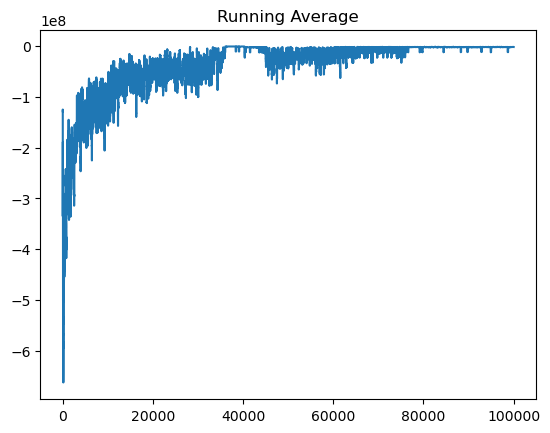

In [9]:
plotRunningAverage(totalRewards_SARSA)

Time = 2
Charge = 20
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.25
Charge = 23.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.5
Charge = 26.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.75
Charge = 29.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 3.0
Charge = 32.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 3.25
Charge = 35.0
Optimal Action = 4
Reward = -2221527.630126968

Time = 3.5
Charge = 39.0
Optimal Action = 4
Reward = -2221527.630126968

Time = 3.75
Charge = 43.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 4.0
Charge = 46.0
Total Reward = -4687187.447382442

Time = 2
Charge = 21
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.25
Charge = 24.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.5
Charge = 27.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.75
Charge = 30.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 3.0
Charge = 33.0
Optimal Action = 3
Reward = -40688.697854

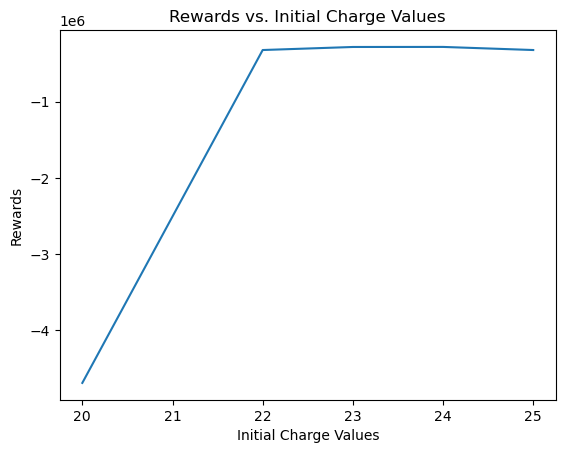

In [10]:
SARSA_rewards, SARSA_final_charges = printOptimalActionsAndRewards(Q_SARSA, 0, env, 20, 25)
plotOptimalRewards(SARSA_rewards, 20, 25)

In [11]:
Q_table_SARSA = getQTable(Q_SARSA)
Q_table_SARSA

,Time,Charge,Action,Value
0,2.0,0,0,0.0
1,2.0,0,1,0.0
2,2.0,0,2,0.0
3,2.0,0,3,0.0
4,2.0,0,4,0.0
...,...,...,...,...
3289,4.0,60,1,0.0
3290,4.0,60,2,0.0
3291,4.0,60,3,0.0
3292,4.0,60,4,0.0


### Q-Learning

Our next approach is the Q-Learning algorithm using epsilon-greedy action selection with epsilon decay.

In [12]:
def maxAction(Q, state):
    """
    Returns the action with the highest Q-value given the current state and Q-table
    
    Args:
        Q: The current Q-table 
        state: The current state
    Returns:
        action: The action with the highest Q-value
    """
    state_tuple = tuple(state)
    values = np.array([Q[state_tuple, a] for a in range(6)])
    action = np.argmax(values)
    return action





#Construct state space
states = []
# Time and charging rate
for i in range(9):
    t = 2 + i * 0.25
    for j in range(61):
          states.append((t,j))

# Initialize Q-table
Q_QL = {}
for s in states:
    for a in range(6):
        Q_QL[s, a] = 0



ALPHA = 0.01
GAMMA = 0.9
EPS = 1.0

# Initialize environment
env = ChargingEnvironment(mu=30, sigma=5, battery_capacity=60, highest_rate=20)

numRounds = 100000
totalRewards_QL = np.zeros(numRounds)
for i in range(numRounds):
    
    # Reset environment before each round
    s = ChargingEnvironment.reset(env)
    rand = np.random.random()
    # Q-Learning algorithm
    a = maxAction(Q_QL, s) if rand < (1-EPS) else env.action_space.sample()
    done = False
    epRewards = 0
    while not done:
        next_state, reward, done, info = ChargingEnvironment.step(env,a)
        s_ = next_state
        rand = np.random.random()
        a_ = maxAction(Q_QL, s_)
        epRewards += reward
        Q_QL[tuple(s), a] = Q_QL[tuple(s), a] + ALPHA * (reward + GAMMA * Q_QL[tuple(s_), a_] - Q_QL[tuple(s), a])
        s, a = s_, a_
    # Epsilon  decay
    EPS -= 2/(numRounds / 100) if EPS > 0 else 0
    totalRewards_QL[i] = epRewards
    if i % 5000 == 0:
        print("Rewards of Round ", i, totalRewards_QL[i])

Rewards of Round  0 -1000040688.6978548
Rewards of Round  5000 -164990.50990928523
Rewards of Round  10000 -2385054.960117749
Rewards of Round  15000 -285566.1244800172
Rewards of Round  20000 -2425730.008434992
Rewards of Round  25000 -325509.5828380078
Rewards of Round  30000 -6747464.414621435
Rewards of Round  35000 -2465673.466792982
Rewards of Round  40000 -2385041.3105802406
Rewards of Round  45000 -2466405.056752234
Rewards of Round  50000 -2425716.3588974834
Rewards of Round  55000 -2506348.5151102245
Rewards of Round  60000 -284820.8849832568
Rewards of Round  65000 -2424998.4184757397
Rewards of Round  70000 -2466405.056752234
Rewards of Round  75000 -2466405.056752234
Rewards of Round  80000 -285566.1244800172
Rewards of Round  85000 -245622.66612202668
Rewards of Round  90000 -284834.53452076507
Rewards of Round  95000 -127996584.09022073


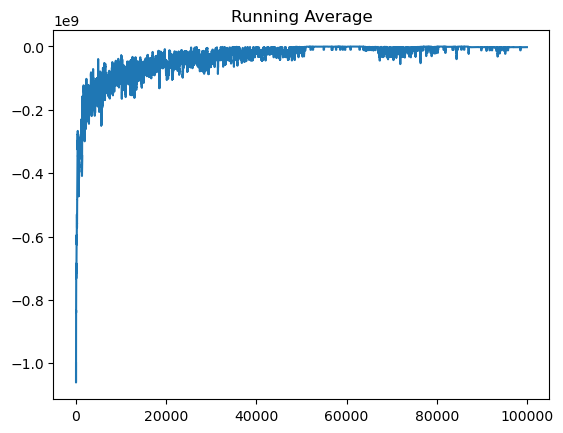

In [13]:
plotRunningAverage(totalRewards_QL)

Time = 2
Charge = 20
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.25
Charge = 23.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.5
Charge = 26.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.75
Charge = 29.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 3.0
Charge = 32.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 3.25
Charge = 35.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 3.5
Charge = 38.0
Optimal Action = 4
Reward = -2221527.630126968

Time = 3.75
Charge = 42.0
Optimal Action = 4
Reward = -2221527.630126968

Time = 4.0
Charge = 46.0
Total Reward = -4687187.447382442

Time = 2
Charge = 21
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.25
Charge = 24.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.5
Charge = 27.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.75
Charge = 30.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 3.0
Charge = 33.0
Optimal Action = 3
Reward = -40688.697854

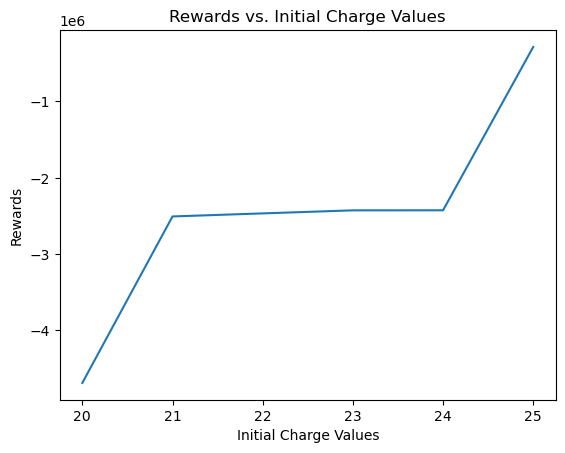

In [14]:
QL_rewards, QL_final_charges = printOptimalActionsAndRewards(Q_QL,0, env, 20, 25)
plotOptimalRewards(QL_rewards, 20, 25)

In [15]:
Q_table_QL = getQTable(Q_QL)
Q_table_QL

,Time,Charge,Action,Value
0,2.0,0,0,0.0
1,2.0,0,1,0.0
2,2.0,0,2,0.0
3,2.0,0,3,0.0
4,2.0,0,4,0.0
...,...,...,...,...
3289,4.0,60,1,0.0
3290,4.0,60,2,0.0
3291,4.0,60,3,0.0
3292,4.0,60,4,0.0


### Double Q-Learning

Finally, we have a look at the performance of Double Q-Learning using epsilon-greedy action selection with epsilon decay.

In [16]:
def maxActionDQL(Q1,Q2,state):
    """
    Returns the action with the highest sum of Q-values given the current state and Q-tables Q1 and Q2
    
    Args:
        Q1: The current Q-table Q1
        Q2: The current Q-table Q2
        state: The current state
    Returns:
        action: The action with the highest sum of Q-values Q1 and Q2
    """
    state_tuple = tuple(state)
    values = np.array([Q1[state_tuple, a] + Q2[state_tuple, a] for a in range(6)])
    action = np.argmax(values)
    return action




# Construct state space
states = []
# Time and charging rate
for i in range(9):
    t = 2 + i * 0.25
    for j in range(61):
          states.append((t,j))

# Initialize Q-tables
Q1, Q2 = {}, {}
for s in states:
    for a in range(6):
        Q1[s, a] = 0
        Q2[s, a] = 0



ALPHA = 0.01
GAMMA = 0.9
EPS = 1.0

# Initialize environment
env = ChargingEnvironment(mu=30, sigma=5, battery_capacity=60, highest_rate=20)

numRounds = 150000
totalRewards_DQL = np.zeros(numRounds)
for i in range(numRounds):

    # Reset the environment before each round
    s = ChargingEnvironment.reset(env)
    rand = np.random.random()
    done = False
    epRewards = 0
    while not done:
        
        # Double Q-Learning algorithm
        rand = np.random.random()
        a = maxActionDQL(Q1,Q2, s) if rand < (1-EPS) else env.action_space.sample()
        next_state, reward, done, info = ChargingEnvironment.step(env,a)
        s_ = next_state
        rand = np.random.random()
        epRewards += reward
        if rand <= 0.5:
            a_ = maxActionDQL(Q1,Q1,s_)
            Q1[tuple(s),a] = Q1[tuple(s),a] + ALPHA*(reward + GAMMA*Q2[tuple(s_),a_] - Q1[tuple(s),a])
        elif rand > 0.5:
            a_ = maxActionDQL(Q2,Q2,s_)
            Q2[tuple(s),a] = Q2[tuple(s),a] + ALPHA*(reward + GAMMA*Q1[tuple(s_),a_] - Q2[tuple(s),a])
          
        s = s_
    # Epsilon decay
    EPS -= 2/(numRounds / 100) if EPS > 0 else 0
    totalRewards_DQL[i] = epRewards
    if i % 5000 == 0:
        print("Rewards of Round ", i, totalRewards_DQL[i])


Rewards of Round  0 -1004443082.5593289
Rewards of Round  5000 -4525205.194535215
Rewards of Round  10000 -6746719.175124675
Rewards of Round  15000 -244159.48620352245
Rewards of Round  20000 -8927571.756934399
Rewards of Round  25000 -124315.46159204253
Rewards of Round  30000 -4484516.496680465
Rewards of Round  35000 -2425730.008434992
Rewards of Round  40000 -4526682.023991227
Rewards of Round  45000 -2385772.900539493
Rewards of Round  50000 -4565880.242852457
Rewards of Round  55000 -4606568.940707209
Rewards of Round  60000 -6747450.765083926
Rewards of Round  65000 -2426461.598394244
Rewards of Round  70000 -2424984.7689382313
Rewards of Round  75000 -6827337.681799907
Rewards of Round  80000 -4646498.74952769
Rewards of Round  85000 -4485275.385714733
Rewards of Round  90000 -4606555.291169701
Rewards of Round  95000 -4607300.530666461
Rewards of Round  100000 -4606568.940707209
Rewards of Round  105000 -123595694.35727757
Rewards of Round  110000 -4565866.593314949
Rewards o

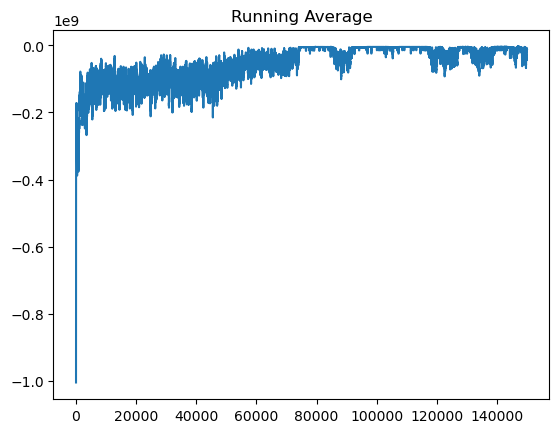

In [17]:
plotRunningAverage(totalRewards_DQL)

Time = 2
Charge = 20
Optimal Action = 4
Reward = -2221527.630126968

Time = 2.25
Charge = 24.0
Optimal Action = 0
Reward = 0

Time = 2.5
Charge = 24.0
Optimal Action = 2
Reward = -745.2394967604321

Time = 2.75
Charge = 26.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 3.0
Charge = 29.0
Optimal Action = 1
Reward = -13.649537508286059

Time = 3.25
Charge = 30.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 3.5
Charge = 33.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 3.75
Charge = 36.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 4.0
Charge = 39.0
Total Reward = -2385041.31058024

Time = 2
Charge = 21
Optimal Action = 2
Reward = -745.2394967604321

Time = 2.25
Charge = 23.0
Optimal Action = 4
Reward = -2221527.630126968

Time = 2.5
Charge = 27.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 2.75
Charge = 30.0
Optimal Action = 3
Reward = -40688.69785475098

Time = 3.0
Charge = 33.0
Optimal Action = 4
Reward = -2221527.630126968

Time = 3.2

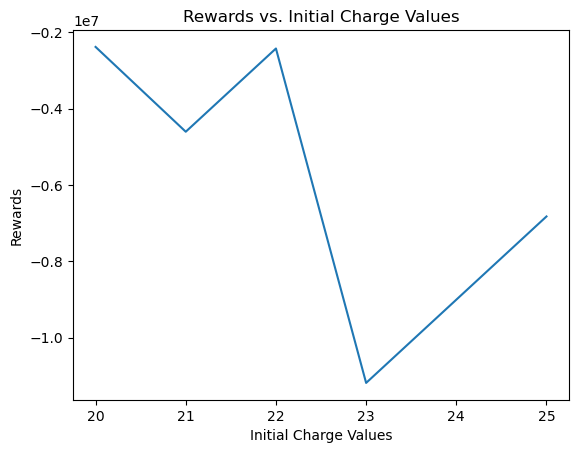

In [18]:
DQL_rewards, DQL_final_charges = printOptimalActionsAndRewards(Q1, Q2, env, 20, 25)
plotOptimalRewards(DQL_rewards, 20, 25)


In [19]:
Q_table_Q1 = getQTable(Q1)
Q_table_Q2 = getQTable(Q2)

## Comparison of  Results

### Rewards and Initial Battery Charges

Let us compare the sum of rewards of the different agents when taking the learnt actions for the different initial values. 

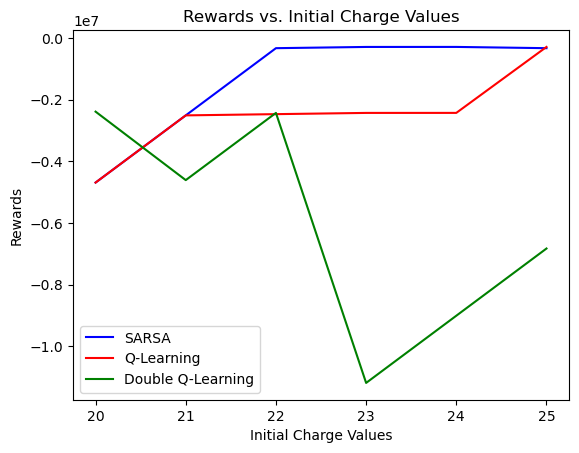

In [20]:
"""
Plots the sum of rewards of the three agents for the initial values of 20-25
"""
plt.plot(SARSA_rewards[20:26], label='SARSA', c='blue')
plt.plot(QL_rewards[20:26], label='Q-Learning', c='red')
plt.plot(DQL_rewards[20:26], label='Double Q-Learning', c='green')
plt.xlabel('Initial Charge Values')
plt.ylabel('Rewards')
plt.title('Rewards vs. Initial Charge Values')
positions = list(range(20, 26))
plt.xticks(range(len(SARSA_rewards[20:26])), positions)
plt.legend()
plt.show()

We can see that the performances are very similar, with SARSA achieving the best performance. However, we need to consider the fact that different iterations can lead to different results since many aspects of the learning process are influenced by random factors. Thus, in some cases, SARSA might have the best performance, in others Q-Learning or Double Q-Learning, using the same hyperparameters as above.

### Final Battery Charges

Lastly, we have a look at the final battery charges that the different agents aim at.

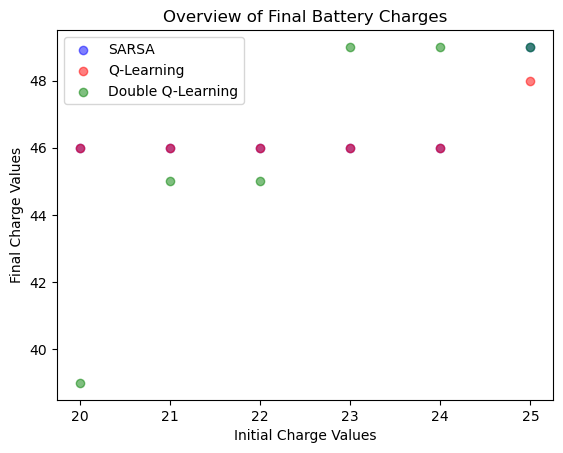

In [21]:
"""
Plots the final battery charges for initial values of 20-25 for the trained agents
"""
x_values = [20, 21, 22, 23, 24, 25]

# Create a scatterplot
plt.scatter(x_values, SARSA_final_charges[20:26], label='SARSA', c='blue', alpha=0.5)
plt.scatter(x_values, QL_final_charges[20:26], label='Q-Learning', c='red', alpha=0.5)
plt.scatter(x_values, DQL_final_charges[20:26], label='Double Q-Learning', c='green', alpha=0.5)



# Add labels and title
plt.xlabel('Initial Charge Values')
plt.ylabel('Final Charge Values')
plt.title('Overview of Final Battery Charges')

# Add a legend
plt.legend()

# Show the plot
plt.show()

We can see that the majority of final battery charges lies in the range of 45 to 50 kWh for a mean of 30 and a standard deviation of 5.. This makes sense, because it is very unlikely for the energy demand to exceed these values. At the same time, the battery does not have a lot of superfluous charge that is basically never required, which would be the case for final charges of 50 and above.